In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cvrp import *

# Importando explicitamente o Enum para iterar sobre as opções
from cvrp.solvers.constructive_heuristics.base_heuristics import ConstructiveHeuristicType

# Configuração para exibir dataframes pandas bonitos
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)

In [2]:
instance_path = "vrp_instances/instance1.vrp"
instance = CvrpInstance.from_file(instance_path)

print(f"Instância Carregada: {instance.name}")
print(f"Dimensão: {instance.dimension} clientes + 1 depósito")
print(f"Capacidade do Veículo: {instance.capacity}")

Instância Carregada: X-n101-k25
Dimensão: 101 clientes + 1 depósito
Capacidade do Veículo: 206


In [3]:
# Configurações do Experimento
constructive_options = [
    ConstructiveHeuristicType.SAVINGS
]

# MUDANÇA 1: Use 'first' para ganhar velocidade e explorar mais bacias de atração
search_strategies = ['best'] 

results = []

print(f"{'Construtiva':<30} | {'Busca':<6} | {'Início':<8} | {'Final':<8} | {'Tempo (s)':<8} | {'Melhoria %':<8}")
print("-" * 90)

# MUDANÇA 2: Adicione 'cross_exchange' se você implementou na classe
BASE_NEIGHBORHOODS = {
    'relocate': True, 
    'swap': True, 
    '2opt': True, 
    'oropt': True,
    'cross_exchange': True # <--- LIGUE ISSO se implementou
}

for cons_heuristic in constructive_options:
    for search_strat in search_strategies:
        
        # 1. Configurar a Estratégia
        strategy = TSStrategy(
            constructive_heuristic=cons_heuristic,
            search_strategy=search_strat,
            neighborhoods=BASE_NEIGHBORHOODS,
            
            # Configuração de Diversificação
            enable_diversification=True, 
            
            # MUDANÇA 3: Ajuste fino da paciência
            # Se for 'first', 200 é ok. Se fosse 'best', eu baixaria para 50.
            diversification_patience=70, 
            diversification_multiplier=1.5,
            max_tenure_multiplier=10.0, # Restart/Shake acontece após ~1000 iterações ruins
            restart_when_max_reached=True,
            
            enable_intensification=False,
            intensification_patience=500
        )
        
        # 2. Configurar Critérios de Parada
        term_criteria = TerminationCriteria(
            max_time_secs=900,      # 15 minutos
            max_no_improvement=50000 
        )
        
        # 3. Instanciar e Resolver
        solver = CvrpTS(
            instance=instance, 
            tenure=7, 
            strategy=strategy, 
            termination_criteria=term_criteria,
            debug_options=DebugOptions(verbose=True, log_history=True) 
        )
        
        solver.solve()
        
        # 4. Coletar Métricas
        initial_cost = solver.history[0][1] if solver.history else solver.best_solution.objfun_val 
        final_cost = solver.best_solution.objfun_val
        improvement = ((initial_cost - final_cost) / initial_cost) * 100
        
        print(f"{cons_heuristic.value:<30} | {search_strat:<6} | {initial_cost:<8.2f} | {final_cost:<8.2f} | {solver.execution_time:<8.4f} | {improvement:<8.2f}%")
        
        results.append({
            'Heurística Construtiva': cons_heuristic.value,
            'Estratégia de Busca': search_strat,
            'Custo Inicial': initial_cost,
            'Custo Final': final_cost,
            'Melhoria (%)': improvement,
            'Tempo (s)': solver.execution_time,
            'Razão de Parada': solver.stop_reason,
            'Histórico': solver.history 
        })

print("-" * 90)

Construtiva                    | Busca  | Início   | Final    | Tempo (s) | Melhoria %
------------------------------------------------------------------------------------------
Generating initial solution using savings...
Iteration 0: Best Cost = 28941.98, Current Cost = 28941.98
Iteration 1: Best Cost = 28861.13, Current Cost = 28861.13
Iteration 2: Best Cost = 28789.04, Current Cost = 28789.04
Iteration 3: Best Cost = 28730.62, Current Cost = 28730.62
Iteration 4: Best Cost = 28680.52, Current Cost = 28680.52
Iteration 5: Best Cost = 28654.50, Current Cost = 28654.50
Iteration 6: Best Cost = 28631.96, Current Cost = 28631.96
Iteration 7: Best Cost = 28616.35, Current Cost = 28616.35
Iteration 8: Best Cost = 28603.57, Current Cost = 28603.57
Iteration 9: Best Cost = 28597.62, Current Cost = 28597.62
Iteration 10: Best Cost = 28586.74, Current Cost = 28586.74
Iteration 11: Best Cost = 28574.55, Current Cost = 28574.55
Iteration 12: Best Cost = 28571.00, Current Cost = 28571.00
Iterati

In [4]:
df_results = pd.DataFrame(results)
# Remove a coluna 'Histórico' da visualização da tabela para ficar limpo
df_display = df_results.drop(columns=['Histórico'])

# Ordenar pelo Custo Final (Menor é melhor)
df_display = df_display.sort_values(by='Custo Final')

print("Ranking das Estratégias:")
display(df_display)

Ranking das Estratégias:


,Heurística Construtiva,Estratégia de Busca,Custo Inicial,Custo Final,Melhoria (%),Tempo (s),Razão de Parada
0,savings,best,28941.98,28068.69,3.02,900.08,max_time_secs



INICIANDO EXPERIMENTO DO REQUISITO 4: Impacto da Intensificação e Diversificação
Cenário                   | Custo Inicial | Custo Final | Tempo (s)  | Melhoria %
------------------------------------------------------------------------------------------
Sem Int / Sem Div         | 28941.98   | 28603.57   | 60.0098    | 1.17      %
Só Intensificação         | 28941.98   | 28603.57   | 60.0058    | 1.17      %
Só Diversificação         | 28941.98   | 28458.07   | 60.0498    | 1.67      %
Completo (Int+Div)        | 28941.98   | 28595.86   | 60.0069    | 1.20      %


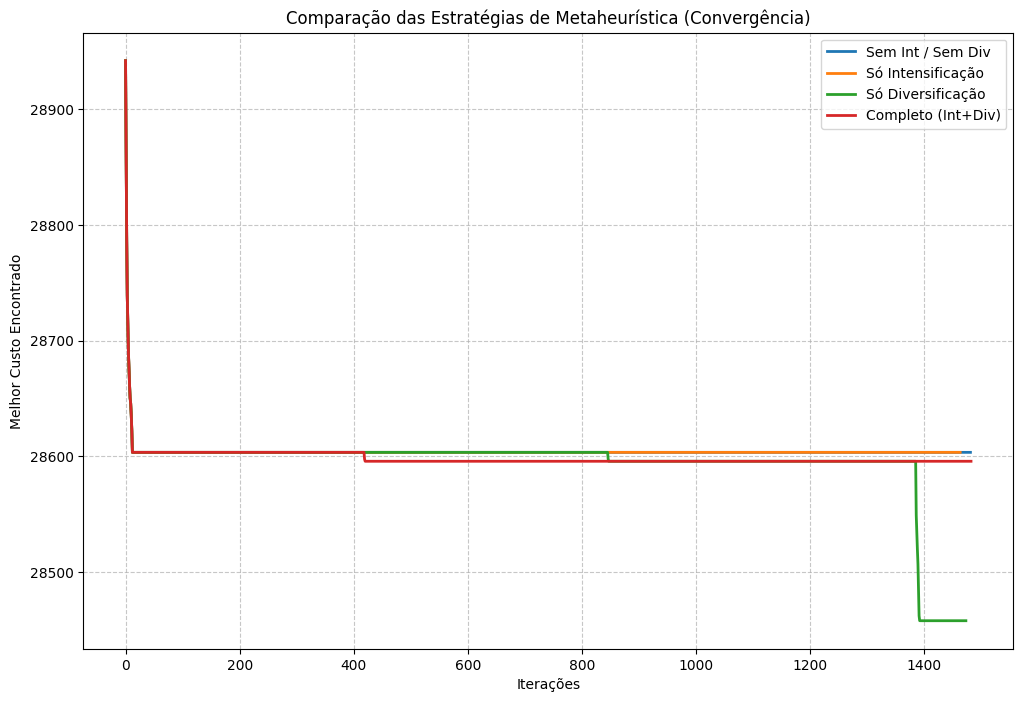

,Cenário,Intensificação,Diversificação,Custo Final,Melhoria (%),Tempo (s)
2,Só Diversificação,False,True,28458.07,1.67,60.05
3,Completo (Int+Div),True,True,28595.86,1.20,60.01
1,Só Intensificação,True,False,28603.57,1.17,60.01
0,Sem Int / Sem Div,False,False,28603.57,1.17,60.01


In [5]:
# --- REQUISITO 4: Análise dos Componentes da Metaheurística ---

print("\n" + "="*100)
print("INICIANDO EXPERIMENTO DO REQUISITO 4: Impacto da Intensificação e Diversificação")
print("="*100)

# Fixamos uma construtiva (geralmente a que teve melhor desempenho médio ou Savings por ser padrão)
# e uma estratégia de busca (Best costuma ser mais estável para análises longas)
FIXED_CONSTRUCTIVE = ConstructiveHeuristicType.SAVINGS 
FIXED_SEARCH = 'best' 

# As 4 configurações exigidas pelo professor
scenarios = [
    {"name": "Sem Int / Sem Div", "int": False, "div": False},
    {"name": "Só Intensificação", "int": True,  "div": False},
    {"name": "Só Diversificação", "int": False, "div": True},
    {"name": "Completo (Int+Div)", "int": True,  "div": True},
]

results_req4 = []

print(f"{'Cenário':<25} | {'Custo Inicial':<10} | {'Custo Final':<10} | {'Tempo (s)':<10} | {'Melhoria %':<10}")
print("-" * 90)

for scen in scenarios:
    
    # 1. Configurar Estratégia com os flags específicos do cenário
    strategy = TSStrategy(
        constructive_heuristic=FIXED_CONSTRUCTIVE,
        search_strategy=FIXED_SEARCH,
        neighborhoods={'relocate': True, 'swap': True, '2opt': True}, # Vizinhança completa
        
        # Configuração do Cenário
        enable_intensification=scen["int"],
        intensification_patience=500, # Ajuste conforme necessário (ex: a cada 500 iters sem melhora)
        
        enable_diversification=scen["div"],
        diversification_patience=100, # Ajuste conforme necessário
        diversification_multiplier=1.5,
        max_tenure_multiplier=5.0,
        restart_when_max_reached=True # Diversificação agressiva
    )
    
    # 2. Critério de Parada (30 minutos = 1800 segundos conforme enunciado)
    # Nota: Para testes rápidos agora, use 60s. Para o relatório final, use 1800s.
    term_criteria = TerminationCriteria(
        max_time_secs=60,    # <--- MUDE PARA 1800 PARA A ENTREGA FINAL
        max_no_improvement=5000 # Dê bastante margem para a diversificação agir
    )
    
    # 3. Resolver
    solver = CvrpTS(
        instance=instance,
        tenure=7,
        strategy=strategy,
        termination_criteria=term_criteria,
        debug_options=DebugOptions(verbose=False, log_history=True)
    )
    
    solver.solve()
    
    # 4. Coletar Dados
    initial_cost = solver.history[0][1] if solver.history else solver.best_solution.objfun_val
    final_cost = solver.best_solution.objfun_val
    improvement = ((initial_cost - final_cost) / initial_cost) * 100
    
    print(f"{scen['name']:<25} | {initial_cost:<10.2f} | {final_cost:<10.2f} | {solver.execution_time:<10.4f} | {improvement:<10.2f}%")
    
    results_req4.append({
        'Cenário': scen['name'],
        'Intensificação': scen['int'],
        'Diversificação': scen['div'],
        'Custo Final': final_cost,
        'Melhoria (%)': improvement,
        'Tempo (s)': solver.execution_time,
        'Histórico': solver.history
    })

# --- Plotagem dos Gráficos do Requisito 4 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for res in results_req4:
    history = res['Histórico']
    # Plotar apenas a evolução do MELHOR custo encontrado (índice 1 da tupla de histórico)
    iterations = [h[0] for h in history]
    best_costs = [h[1] for h in history]
    
    plt.plot(iterations, best_costs, label=res['Cenário'], linewidth=2)

plt.xlabel('Iterações')
plt.ylabel('Melhor Custo Encontrado')
plt.title('Comparação das Estratégias de Metaheurística (Convergência)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Tabela final para o relatório
df_req4 = pd.DataFrame(results_req4).drop(columns=['Histórico'])
display(df_req4.sort_values(by='Custo Final'))